
# Hands-on session on Digital Volume Correlation with SPAM

@ Olga Stamati: olga.stamati@esfr.fr



## Outline

- What is <tt>SPAM<tt>?
- Let's load an X-ray image
- Local DVC
- Discrete DVC    
- Global DVC
- <font color="red">**Multimodal registration**</font> 


## Multimodal registration

Our objective here is to register two images acquired with different modalities


## Load and plot the two images



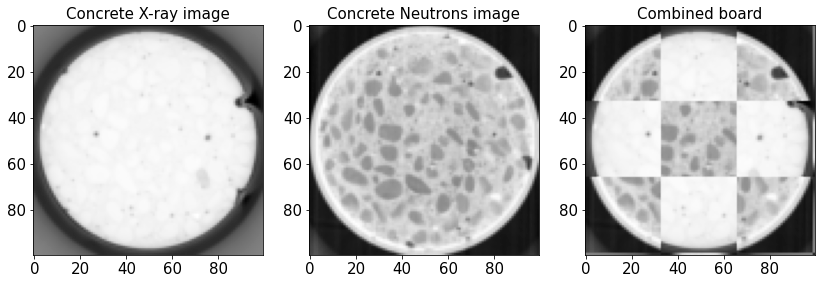

In [15]:
import spam.datasets; spam.DIC
import matplotlib.pyplot as plt; plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15

xr = spam.datasets.loadConcreteXr().astype('<f4')
ne = spam.datasets.loadConcreteNe().astype('<f4')

plt.figure(figsize=(14, 14))
plt.subplot(1, 3, 1); plt.title("Concrete X-ray image", fontsize=15)
plt.imshow(xr[xr.shape[0]//2, :, :], cmap="Greys_r")
plt.subplot(1, 3, 2); plt.title("Concrete Neutrons image", fontsize=15)
plt.imshow(ne[ne.shape[0]//2, :, :], cmap="Greys_r")
plt.subplot(1, 3, 3); plt.title("Combined board", fontsize=15)
plt.imshow(spam.DIC.checkerBoard(xr[halfSlice], ne[halfSlice], n=3), cmap="Greys_r")

### Preparation of the images
 
We start to crop the images to:
   1. select a region of interest: ``crop``
   2. keep some margin to feed the transformation: ``margin``



In [7]:
import spam.DIC
import spam.deformation
import spam.datasets

In [10]:
cropRatio = 0.1
crop = (slice(int(cropRatio * xr.shape[0]), int((1 - cropRatio) * xr.shape[0])),
        slice(int(cropRatio * xr.shape[1]), int((1 - cropRatio) * xr.shape[1])),
        slice(int(cropRatio * xr.shape[2]), int((1 - cropRatio) * xr.shape[2])))
cropPx = int(cropRatio * numpy.mean(xr.shape[0]))
marginRatio = 0.1
marginPx = int(marginRatio * numpy.mean(xr.shape[0]))
cropWithMargin = (slice(int((cropRatio + marginRatio) * xr.shape[0]), int((1 - (cropRatio + marginRatio)) * xr.shape[0])),
                  slice(int((cropRatio + marginRatio) * xr.shape[1]), int((1 - (cropRatio + marginRatio)) * xr.shape[1])),
                  slice(int((cropRatio + marginRatio) * xr.shape[2]), int((1 - (cropRatio + marginRatio)) * xr.shape[2])))

### Rescale of images

We rescale the two images between 0 and the number of bins in the joint histogram.


In [18]:
bins = 128
xrMin = xr.min()
xrMax = xr.max()
neMax = ne.max()
neMin = ne.min()
xr = numpy.array(bins * (xr - xrMin) / (xrMax - xrMin)).astype('<u1')
ne = numpy.array(bins * (ne - neMin) / (neMax - neMin)).astype('<u1')

### Initial guess

No surprise here!<br> 
We should first apply an initial transformation.

This can come by `spam-ereg`, which is a GUI for an eye registration of two images.<br>
You're welcome to try!

----
**NOTE**:<br>
A bit of a spoiler here, a Z-rotation of 15° is a sufficient initial guess.

In [ ]:
PhiGuess = spam.deformation.computePhi({'r': [15.0, 0.0, 0.0]})
tmp = spam.deformation.decomposePhi(PhiGuess)
neTmp = spam.DIC.applyPhi(ne.copy(), Phi=PhiGuess).astype('<u1')
print("Rotations   : {:.4f}, {:.4f}, {:.4f}".format(*tmp['r']))

## Multimodal registration algorithm
 
 It is again an iterative algorithm. <br>
 But this time we need to add some more information in our algorithm.<br>
 
 1. We compute the joint histogram of the two images
 2. We get the parameters of the fitted gaussians: two ellipsoids that fit the two peaks
 3. Create the phase diagram


In [20]:
print("STEP 0: Apply an initial transformation guess")
PhiGuess = spam.deformation.computePhi({'r': [15.0, 0.0, 0.0]})
neTmp = spam.DIC.applyPhi(ne.copy(), Phi=PhiGuess).astype('<u1')

print("STEP 1-2: Compute joint histogram and get gaussian parameters")
nPhases = 2
gaussianParameters, jointHistogram = spam.DIC.gaussianMixtureParameters(xr[cropWithMargin],
                                                                        neTmp[cropWithMargin],
                                                                        BINS=bins,
                                                                        NPHASES=nPhases)

STEP 0: Apply an initial transformation guess
STEP 1: Get gaussian parameters
	im1 from 29.00 to 128.00
	im2 from 23.00 to 122.00
	p normalisation: 1.00
	Find maxima
		Min distance between maxima: 5
		00 maxima found over the 2 needed with 1.00e-01 times of the total count
		00 maxima found over the 2 needed with 1.00e-02 times of the total count
		02 maxima found over the 2 needed with 1.00e-03 times of the total count
		Maximum 1:	 mu1=108.00	 mu2=86.00	 Phi=8.63e-03
		Maximum 2:	 mu1=109.00	 mu2=67.00	 Phi=3.59e-03

	Phase  1:		 mu1=108.00	 mu2=86.00	 Phi=8.63e-03
		Fit:		 a=0.18	 b=0.02	 c=0.04	 Hessian: 0.01
		Cov:		 1,1=5.8691	 1,2=-3.3674	 2,2=30.3347

	Phase  2:		 mu1=109.00	 mu2=67.00	 Phi=3.59e-03
		Fit:		 a=0.15	 b=-0.00	 c=0.00	 Hessian: 0.00
		Cov:		 1,1=6.6323	 1,2=0.8708	 2,2=323.2468



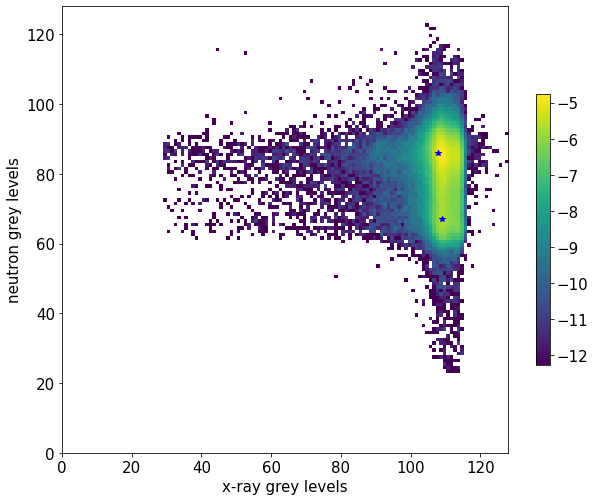

In [22]:
plt.figure(figsize=(10, 10))
tmp = jointHistogram.copy()
tmp[jointHistogram <= 0] = numpy.nan
tmp = numpy.log(tmp)
plt.imshow(tmp.T, origin='lower', extent=[0.0, bins, 0.0, bins])
plt.xlabel("x-ray grey levels", fontsize=15)
plt.ylabel("neutron grey levels", fontsize=15)
plt.colorbar(shrink=0.5)
for gp in gaussianParameters: plt.plot(gp[1], gp[2], 'b*')

### Phase diagram

We can now create the phase diagram based on the joint histogram.<br>
Each peak corresponds to a phase (1 and 2).<br>
The grey background (points too far away from a peak) is ignored (0).

STEP 3: Create phase repartition
	9-sigma: voxel coverage = 99.15 (> 99.00%)
	8-sigma: voxel coverage = 98.99 (< 99.00%) -> Returning this phase diagram.


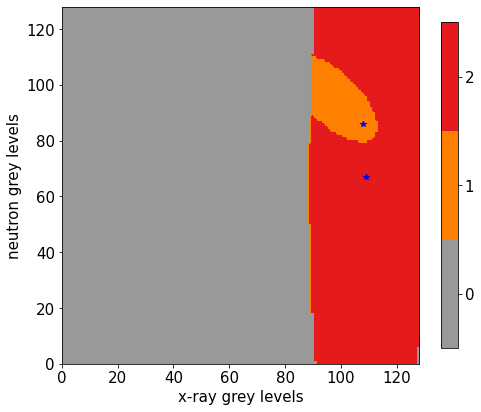

In [27]:
print("STEP 3: Create phase repartition")
phaseDiagram, actualVoxelCoverage = spam.DIC.phaseDiagram(gaussianParameters, jointHistogram,
                                                          voxelCoverage=0.99, BINS=bins)
plt.figure(figsize=(8, 8))
plt.imshow(phaseDiagram.T, origin='lower', extent=[0.0, bins, 0.0, bins], vmin=-0.5, vmax=nPhases + 0.5, cmap=plt.cm.get_cmap('Set1_r', nPhases + 1))
plt.xlabel("x-ray grey levels", fontsize=15); plt.ylabel("neutron grey levels", fontsize=15)
plt.colorbar(ticks=numpy.arange(0, nPhases + 1), shrink=0.75)
for gp in gaussianParameters: plt.plot(gp[1], gp[2], 'b*')

### Run registration algorithm

We can use now both Gaussian parameters and phase diagram as an input of the registration algorithm:


In [28]:
print("STEP 4: Registration")
registration = spam.DIC.multimodalRegistration(xr, ne,
                                               phaseDiagram, gaussianParameters, 
                                               BINS=bins, PhiInit=PhiGuess,
                                               verbose=True, margin=marginPx,
                                               maxIterations=50, deltaPhiMin=0.005)

STEP 4: Registration
	Initial state        LL = 13699.66
	Iteration Number 000 LL = 13699.66 dPhi = 0.0000 Tr =  0.000,  0.000,  0.000 Ro =  15.000,  0.000,  0.000 Zo =  1.000,  1.000,  1.000 
	Iteration Number 001 LL = 13531.89 dPhi = 0.0585 Tr = -0.041,  0.003,  0.041 Ro =  15.137,  0.020, -0.010 Zo =  1.000,  0.999,  0.998 
	Iteration Number 002 LL = 13384.98 dPhi = 0.0550 Tr = -0.077,  0.007,  0.082 Ro =  15.282,  0.039, -0.021 Zo =  0.999,  0.997,  0.996 
	Iteration Number 003 LL = 13279.62 dPhi = 0.0533 Tr = -0.115,  0.011,  0.120 Ro =  15.433,  0.059, -0.034 Zo =  0.998,  0.995,  0.994 
	Iteration Number 004 LL = 13139.97 dPhi = 0.0531 Tr = -0.154,  0.015,  0.154 Ro =  15.594,  0.082, -0.044 Zo =  0.998,  0.994,  0.993 
	Iteration Number 005 LL = 13046.46 dPhi = 0.0538 Tr = -0.196,  0.019,  0.187 Ro =  15.764,  0.106, -0.058 Zo =  0.997,  0.993,  0.991 
	Iteration Number 006 LL = 12939.69 dPhi = 0.0549 Tr = -0.242,  0.022,  0.217 Ro =  15.938,  0.129, -0.068 Zo =  0.996,  0.992,

## Let's check the computed deformation function

We can now apply the final transformation


In [33]:
PhiReg = registration['Phi']
neReg = spam.DIC.applyPhi(ne, Phi=PhiReg)

print("\nRegistration output")
for key, value in list(spam.deformation.decomposePhi(PhiReg).items())[:2]: print(key,':',value) 


Registration output
t : [-1.199  0.256  0.62 ]
r : [19.59   0.563 -0.075]


### Let's check the validity of the result

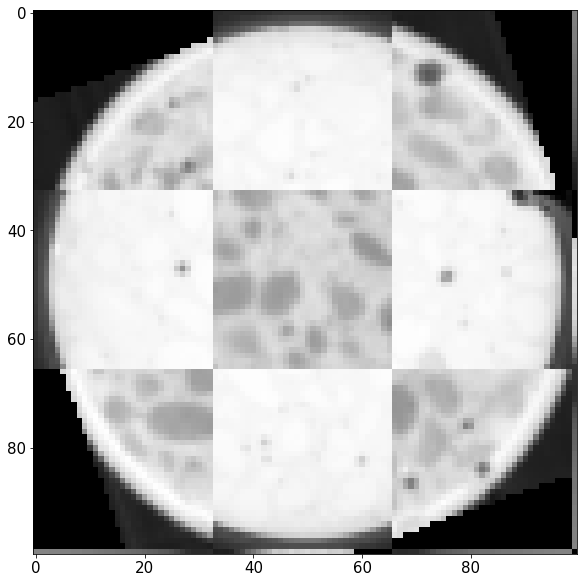

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(spam.DIC.checkerBoard(xr[halfSlice], neReg[halfSlice], n=3), cmap="Greys_r")

### Phase Segmentation

From the phase diagram a segemntation can also directly be obtained. <br>
We can check that phase 1 corresponds to the mortar matrix and phase 2 to the aggregates

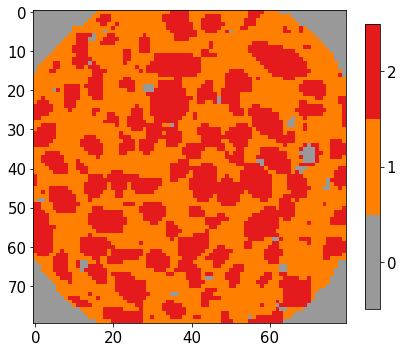

In [40]:
plt.figure(figsize=(7, 7))
plt.imshow(registration["phaseField"][halfSlice, :, :], vmin=-0.5, vmax=nPhases + 0.5, cmap=plt.cm.get_cmap('Set1_r', nPhases + 1))
plt.colorbar(ticks=numpy.arange(0, nPhases + 1), shrink=0.75)

In [1]:
! spam-ereg

/home/ostamati/Downloads/IntACT/V4/VEC4-01-b2.tif
('VEC4-01-b2', '.tif')
